In [ ]:
## Install required libraries
! python -m pip install --upgrade pip --quiet
! pip install spacy --quiet
! pip3 install spacy-transformers --quiet
! python -m spacy download en_core_web_md --quiet

import en_core_web_md
#Load pretrained bert model
nlp = en_core_web_md.load()

# function for generating sentence embedding from text
def get_embeddinngs(text):
    return nlp(text).vector

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 9.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
# load libraries for accessing the data and manipulation
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#custom list of stopwords 
new_stopwords = ['embargoed', 'mistake', 'opinion', 'chrome', 'google chrome', 'ffmpeg', 'django', 'httpd', 'struts', 'vulnerability', 'vulenrability', 'cve']

# add custom list to stopword list of nltk 
stop_words= nltk.corpus.stopwords.words('english')
stop_words.extend(new_stopwords)


In [ ]:
data = pd.read_json('corpus2.json')
data = data.replace(np.nan, '', regex=True)

                id
count   726.000000
mean   1136.870523
std     502.082985
min       9.000000
25%     899.750000
50%    1238.500000
75%    1472.750000
max    2191.000000


In [ ]:
data = data.loc[data['mistakes'] != " " ]
data['mistakes'] = data.mistakes.apply(lambda x: " ".join(re.sub(r'[^a-zA-Z]',' ',w).lower() for w in x.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words))
data['description'] = data.description.apply(lambda x: " ".join(re.sub(r'[^a-zA-Z]',' ',w).lower() for w in x.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words))
data['information'] = data['description'] + data['mistakes']

In [ ]:
# generating sentence embedding from text
data['emb'] = data['information'].apply(get_embeddinngs)

In [ ]:
from nltk.cluster import KMeansClusterer
import nltk
from scipy.spatial import distance_matrix

def clustering_question(data,NUM_CLUSTERS = 15):

    sentences = data['information']

    X = np.array(data['emb'].tolist())

    kclusterer = KMeansClusterer(
        NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,
        repeats=25,avoid_empty_clusters=True)

    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

    data['cluster'] = pd.Series(assigned_clusters, index=data.index)
    data['centroid'] = data['cluster'].apply(lambda x: kclusterer.means()[x])

    return data, assigned_clusters

**Cluster Value K = 10**

In [ ]:
clustering_question(data,10)

(       id            cve project_name  \
 0    1037  CVE-2014-7948     chromium   
 1    1158  CVE-2015-6757     chromium   
 2    1489  CVE-2017-5125     chromium   
 3     184  CVE-2010-4488     chromium   
 4    1269  CVE-2016-1682     chromium   
 ..    ...            ...          ...   
 721   928  CVE-2014-1715     chromium   
 722  1853  CVE-2014-0116       struts   
 723  1421  CVE-2017-5055     chromium   
 724    55  CVE-2010-0656     chromium   
 725  1478  CVE-2017-5113     chromium   
 
                                            description  \
 0    google caches pages despite ssl certificate er...   
 1    trying access data serviceworker freed  creati...   
 2                       embargoed  heap overflow skia    
 3    bug involves unhandled case user behind proxy ...   
 4    checks verify content security policy  csp  re...   
 ..                                                 ...   
 721  path traversal lead creating junction point  a...   
 722  fix applied prev

In [ ]:
def distance_from_centroid(row):
    # type of emb and centroid is different, hence using tolist below
    return distance_matrix([row['emb']], [row['centroid'].tolist()])[0][0]

# Compute centroid distance to the data
data['distance_from_centroid'] = data.apply(distance_from_centroid, axis=1)

In [ ]:
data.head()

,id,cve,project_name,description,mistakes,tag_list,information,emb,cluster,centroid,distance_from_centroid
0,1037,CVE-2014-7948,chromium,google caches pages despite ssl certificate er...,think interesting difficult find test for mad...,"[{'id': 8, 'tag': 'bounty'}, {'id': 95, 'tag':...",google caches pages despite ssl certificate er...,"[-0.105975516, 0.5173467, 0.15558748, -0.32780...",3,"[-0.12732814, 0.40876734, -0.008454129, 0.1681...",6.555417
1,1158,CVE-2015-6757,chromium,trying access data serviceworker freed creati...,made basic c coding mistake freeing data tryi...,"[{'id': 5, 'tag': 'lifetime-1y2y'}, {'id': 8, ...",trying access data serviceworker freed creati...,"[-0.48822913, 0.14428464, -0.33755672, 0.30043...",6,"[-0.6411263, 0.38534155, -0.593216, 0.11505392...",8.554746
2,1489,CVE-2017-5125,chromium,embargoed heap overflow skia,,"[{'id': 14, 'tag': 'cwe-119'}, {'id': 357, 'ta...",embargoed heap overflow skia,"[0.07962601, -0.01970005, 0.08054595, 1.162258...",1,"[-0.1498187, 1.2124096, 0.9775591, 0.69937646,...",12.534714
3,184,CVE-2010-4488,chromium,bug involves unhandled case user behind proxy ...,could coding design error obviously system de...,"[{'id': 3, 'tag': 'lifetime-90d180d'}, {'id': ...",bug involves unhandled case user behind proxy ...,"[0.009807668, 0.36899608, -0.19835448, -0.0338...",5,"[-0.31512028, 0.8485229, -0.7730634, -0.175675...",5.755049
4,1269,CVE-2016-1682,chromium,checks verify content security policy csp re...,seems though developer didn t think check csp ...,"[{'id': 1, 'tag': 'lifetime-30d'}, {'id': 8, '...",checks verify content security policy csp re...,"[-0.60815555, 1.0392046, -1.0995181, -0.010842...",5,"[-0.31512028, 0.8485229, -0.7730634, -0.175675...",8.895950


In [ ]:
data.to_csv('data_after_clustering(10).csv')

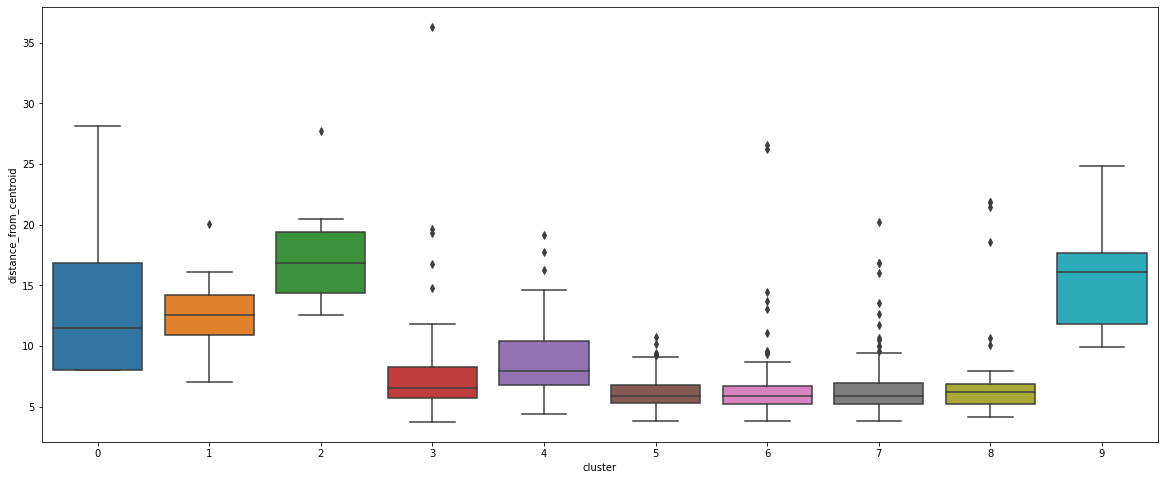

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,8))
ax = sns.boxplot(x="cluster", y="distance_from_centroid", data=data)

In [ ]:
#Average distance from the centroid 
avg = data['distance_from_centroid'].mean()
print(avg)

7.738236808444496


**Cluster K=20**

In [ ]:
clustering_question(data,20)

(       id            cve project_name  \
 0    1037  CVE-2014-7948     chromium   
 1    1158  CVE-2015-6757     chromium   
 2    1489  CVE-2017-5125     chromium   
 3     184  CVE-2010-4488     chromium   
 4    1269  CVE-2016-1682     chromium   
 ..    ...            ...          ...   
 721   928  CVE-2014-1715     chromium   
 722  1853  CVE-2014-0116       struts   
 723  1421  CVE-2017-5055     chromium   
 724    55  CVE-2010-0656     chromium   
 725  1478  CVE-2017-5113     chromium   
 
                                            description  \
 0    google caches pages despite ssl certificate er...   
 1    trying access data serviceworker freed  creati...   
 2                       embargoed  heap overflow skia    
 3    bug involves unhandled case user behind proxy ...   
 4    checks verify content security policy  csp  re...   
 ..                                                 ...   
 721  path traversal lead creating junction point  a...   
 722  fix applied prev

In [ ]:
def distance_from_centroid(row):
    # type of emb and centroid is different, hence using tolist below
    return distance_matrix([row['emb']], [row['centroid'].tolist()])[0][0]

# Compute centroid distance to the data
data['distance_from_centroid'] = data.apply(distance_from_centroid, axis=1)

In [ ]:
data.head()

,id,cve,project_name,description,mistakes,tag_list,information,emb,cluster,centroid,distance_from_centroid
0,1037,CVE-2014-7948,chromium,google caches pages despite ssl certificate er...,think interesting difficult find test for mad...,"[{'id': 8, 'tag': 'bounty'}, {'id': 95, 'tag':...",google caches pages despite ssl certificate er...,"[-0.105975516, 0.5173467, 0.15558748, -0.32780...",8,"[-0.1255907, 0.2566372, 0.05852069, 0.1332874,...",6.430942
1,1158,CVE-2015-6757,chromium,trying access data serviceworker freed creati...,made basic c coding mistake freeing data tryi...,"[{'id': 5, 'tag': 'lifetime-1y2y'}, {'id': 8, ...",trying access data serviceworker freed creati...,"[-0.48822913, 0.14428464, -0.33755672, 0.30043...",16,"[-0.652164, 0.3617504, -0.48024237, 0.19728942...",8.084053
2,1489,CVE-2017-5125,chromium,embargoed heap overflow skia,,"[{'id': 14, 'tag': 'cwe-119'}, {'id': 357, 'ta...",embargoed heap overflow skia,"[0.07962601, -0.01970005, 0.08054595, 1.162258...",1,"[-0.24141712, 1.247912, 0.9419275, 0.7591089, ...",13.104475
3,184,CVE-2010-4488,chromium,bug involves unhandled case user behind proxy ...,could coding design error obviously system de...,"[{'id': 3, 'tag': 'lifetime-90d180d'}, {'id': ...",bug involves unhandled case user behind proxy ...,"[0.009807668, 0.36899608, -0.19835448, -0.0338...",5,"[-0.18644924, 0.71086425, -0.4146406, -0.06721...",5.019777
4,1269,CVE-2016-1682,chromium,checks verify content security policy csp re...,seems though developer didn t think check csp ...,"[{'id': 1, 'tag': 'lifetime-30d'}, {'id': 8, '...",checks verify content security policy csp re...,"[-0.60815555, 1.0392046, -1.0995181, -0.010842...",7,"[-0.08108986, 1.1666416, -0.87740266, -0.26588...",8.404587


In [ ]:
data.to_csv('data_after_clustering(20).csv')

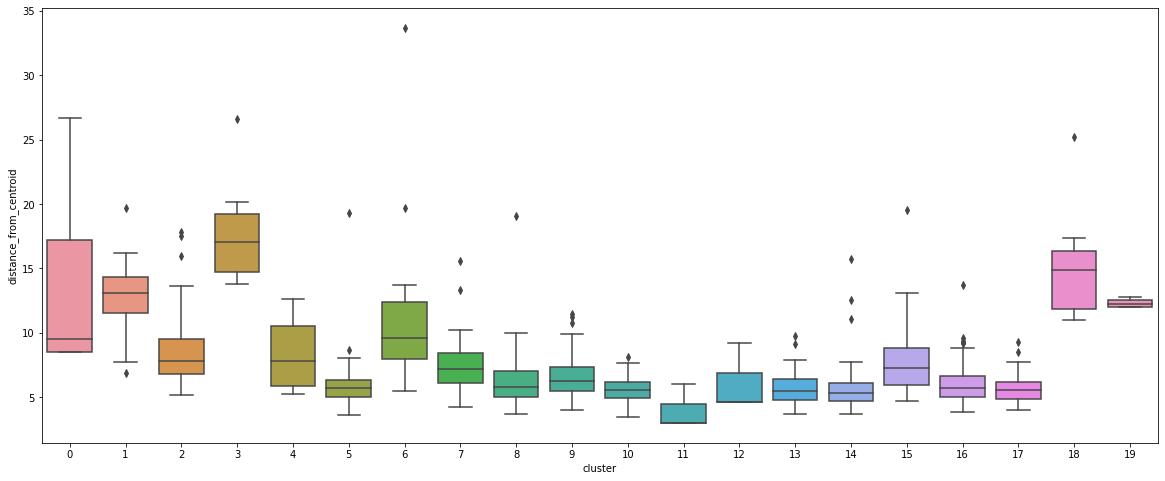

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,8))
ax = sns.boxplot(x="cluster", y="distance_from_centroid", data=data)

In [ ]:
#Average distance from the centroid 
avg = data['distance_from_centroid'].mean()
print(avg)

7.324634585866786


**Clustering Value K = 113**

In [ ]:
clustering_question(data,113)

(       id            cve project_name  \
 0    1037  CVE-2014-7948     chromium   
 1    1158  CVE-2015-6757     chromium   
 2    1489  CVE-2017-5125     chromium   
 3     184  CVE-2010-4488     chromium   
 4    1269  CVE-2016-1682     chromium   
 ..    ...            ...          ...   
 721   928  CVE-2014-1715     chromium   
 722  1853  CVE-2014-0116       struts   
 723  1421  CVE-2017-5055     chromium   
 724    55  CVE-2010-0656     chromium   
 725  1478  CVE-2017-5113     chromium   
 
                                            description  \
 0    google caches pages despite ssl certificate er...   
 1    trying access data serviceworker freed  creati...   
 2                       embargoed  heap overflow skia    
 3    bug involves unhandled case user behind proxy ...   
 4    checks verify content security policy  csp  re...   
 ..                                                 ...   
 721  path traversal lead creating junction point  a...   
 722  fix applied prev

In [ ]:
def distance_from_centroid(row):
    # type of emb and centroid is different, hence using tolist below
    return distance_matrix([row['emb']], [row['centroid'].tolist()])[0][0]

# Compute centroid distance to the data
data['distance_from_centroid'] = data.apply(distance_from_centroid, axis=1)

In [ ]:
data.head()

,id,cve,project_name,description,mistakes,tag_list,information,emb,cluster,centroid,distance_from_centroid
0,1037,CVE-2014-7948,chromium,google caches pages despite ssl certificate er...,think interesting difficult find test for mad...,"[{'id': 8, 'tag': 'bounty'}, {'id': 95, 'tag':...",google caches pages despite ssl certificate er...,"[-0.105975516, 0.5173467, 0.15558748, -0.32780...",62,"[-0.20879202, 0.3699062, 0.18827546, -0.139528...",6.309501
1,1158,CVE-2015-6757,chromium,trying access data serviceworker freed creati...,made basic c coding mistake freeing data tryi...,"[{'id': 5, 'tag': 'lifetime-1y2y'}, {'id': 8, ...",trying access data serviceworker freed creati...,"[-0.48822913, 0.14428464, -0.33755672, 0.30043...",84,"[-0.44770867, 0.6200955, -0.9122674, 0.1885489...",7.813740
2,1489,CVE-2017-5125,chromium,embargoed heap overflow skia,,"[{'id': 14, 'tag': 'cwe-119'}, {'id': 357, 'ta...",embargoed heap overflow skia,"[0.07962601, -0.01970005, 0.08054595, 1.162258...",9,"[-0.1810142, 0.33718285, -0.03628646, 1.303604...",5.103852
3,184,CVE-2010-4488,chromium,bug involves unhandled case user behind proxy ...,could coding design error obviously system de...,"[{'id': 3, 'tag': 'lifetime-90d180d'}, {'id': ...",bug involves unhandled case user behind proxy ...,"[0.009807668, 0.36899608, -0.19835448, -0.0338...",35,"[-0.10406178, 0.7332483, -0.59366125, -0.13836...",4.925525
4,1269,CVE-2016-1682,chromium,checks verify content security policy csp re...,seems though developer didn t think check csp ...,"[{'id': 1, 'tag': 'lifetime-30d'}, {'id': 8, '...",checks verify content security policy csp re...,"[-0.60815555, 1.0392046, -1.0995181, -0.010842...",13,"[-0.075910114, 0.9092741, -1.0052463, 0.116289...",6.696771


In [ ]:
data.to_csv('data_after_clustering(113).csv')

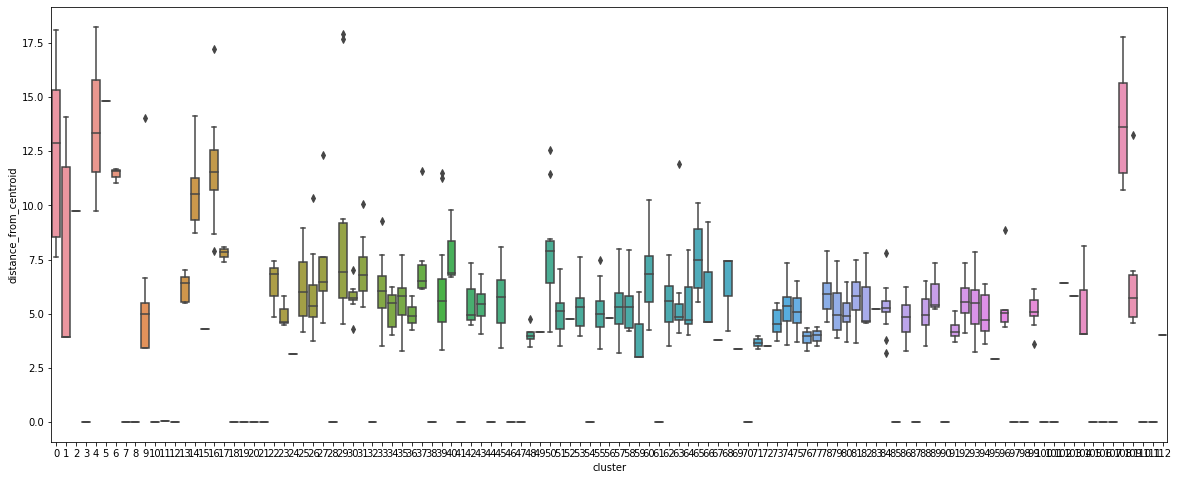

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,8))
ax = sns.boxplot(x="cluster", y="distance_from_centroid", data=data)

In [ ]:
#Average distance from the centroid 
avg = data['distance_from_centroid'].mean()
print(avg)

5.95468816061268
